# Shipment Forecast

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV 
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from scipy.optimize import minimize

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 

In [3]:
pos_data = pd.read_csv('data/pos.csv')
pos_data.head()

,Date,Sales
0,2011-01-01,266.0
1,2011-02-01,145.9
2,2011-03-01,183.1
3,2011-04-01,119.3
4,2011-05-01,180.3


In [4]:
pos_data.isna().sum()

Date     0
Sales    0
dtype: int64

In [5]:
promo_data = pd.read_csv('data/promo.csv', header=None)
promo_data.head()

,0,1
0,2011-11-01,BlackFriday
1,2012-11-01,BlackFriday
2,2013-11-01,BlackFriday


In [6]:
shipment_data = pd.read_csv('data/shipment.csv')
shipment_data.head()

,Date,Shipments
0,2011-01-01,100
1,2011-02-01,319
2,2011-03-01,247
3,2011-04-01,238
4,2011-05-01,214


In [7]:
shipment_data.isna().sum()

Date         0
Shipments    0
dtype: int64

In [8]:
pos_data.Date = pd.to_datetime(pos_data.Date)

promo_data.rename({0:'Date', 1:'BlackFriday'}, axis=1, inplace=True)
promo_data.Date = pd.to_datetime(promo_data.Date)

shipment_data.Date = pd.to_datetime(shipment_data.Date)

In [9]:
pos_data = pos_data.set_index('Date')
promo_data = promo_data.set_index('Date')
shipment_data = shipment_data.set_index('Date')

In [10]:
data = pd.concat([pos_data, promo_data, shipment_data], axis=1)
data.BlackFriday = data.BlackFriday.replace("BlackFriday", 1)
data = data.fillna(0)
data

,Sales,BlackFriday,Shipments
Date,,,
2011-01-01,266.0,0.0,100
2011-02-01,145.9,0.0,319
2011-03-01,183.1,0.0,247
2011-04-01,119.3,0.0,238
2011-05-01,180.3,0.0,214
2011-06-01,168.5,0.0,188
2011-07-01,231.8,0.0,195
2011-08-01,224.5,0.0,209
2011-09-01,192.8,0.0,241


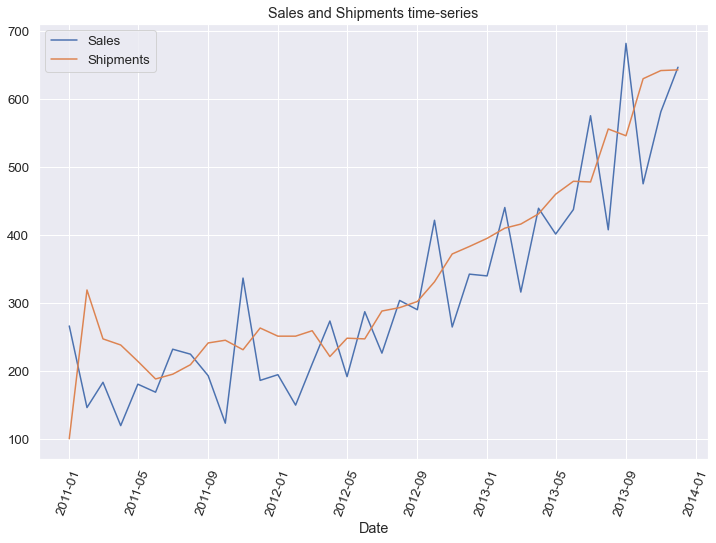

In [11]:
sns.set_style('darkgrid')
sns.set(font_scale = 1.2)

plt.figure(figsize=(12,8))
plt.title('Sales and Shipments time-series')
sns.lineplot(x='Date', y='Sales', data=data, label='Sales')
sns.lineplot(x='Date', y='Shipments', data=data, label='Shipments')
plt.legend()
plt.ylabel('')
plt.xticks(rotation=70);

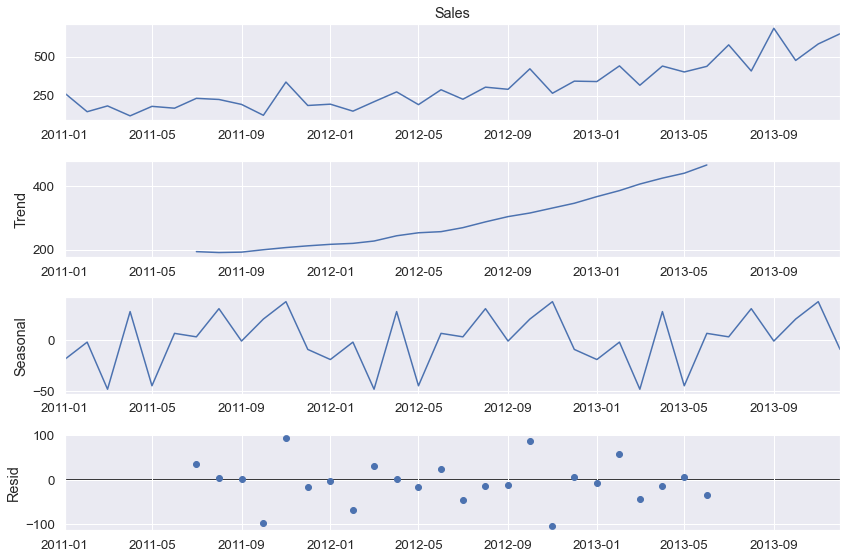

In [13]:
sales_decomp = seasonal_decompose(pos_data.Sales)
sales_decomp.plot()
plt.rcParams.update({'figure.figsize': (12,8)})
plt.show()

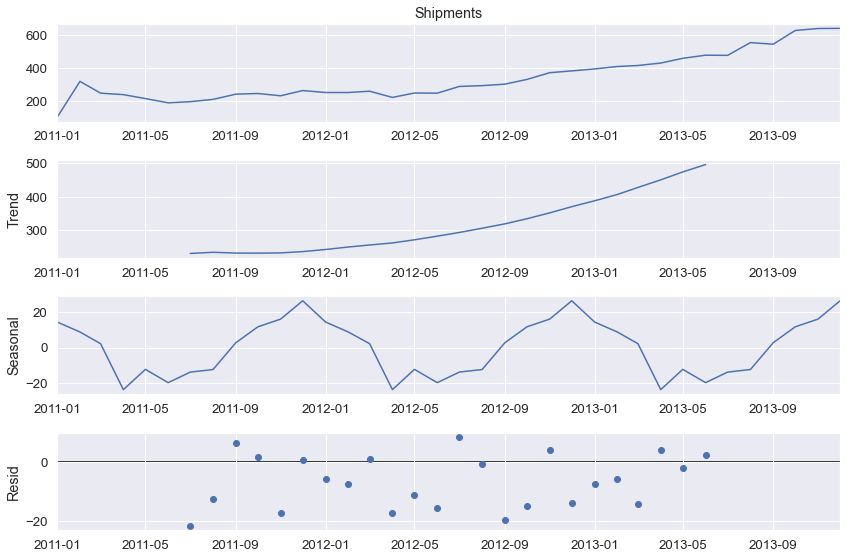

In [14]:
shipment_decomp = seasonal_decompose(shipment_data.Shipments)
shipment_decomp.plot()
plt.rcParams.update({'figure.figsize': (12,8)})
plt.show()

In [ ]:
shipment_decomp = seasonal_decompose(np.log(shipment_data.Shipments))
shipment_decomp.trend.plot()
plt.rcParams.update({'figure.figsize': (6,8)})
plt.show()

## Moving average

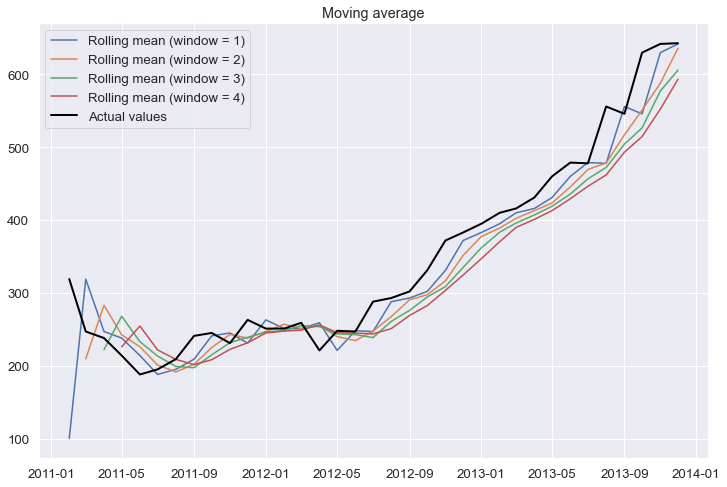

,1,2,3,4
mape,0.086088,0.083432,0.094687,0.107808
mae,27.342857,27.470588,33.010101,39.023438


In [15]:
window_sizes = [1, 2, 3, 4]

mae_errors, mape_errors = [], []

plt.figure(figsize=(12,8))
plt.title('Moving average')

for window in window_sizes:
    rolling_mean = data.Shipments.rolling(window=window).mean().shift(1)
    plt.plot(rolling_mean, label='Rolling mean (window = {})'.format(window))
    
    mae_errors.append(mae(data.Shipments[window:], rolling_mean[window:]))
    mape_errors.append(mape(data.Shipments[window:], rolling_mean[window:]))

plt.plot(data.Shipments[1:], label='Actual values', color='black', linewidth=2)
plt.legend(loc='best')
plt.show()

df_metrics = pd.DataFrame({'mape':mape_errors, 
                           'mae':mae_errors
                          }).T
df_metrics.columns = window_sizes
display(df_metrics)

## Exponential Smoothing

### Simple exponential smoothing

In [16]:
def exp_smooth_score(x):
    mape_errors = []
    mae_errors = []
    predicted_values = []
    eval_result = {}
    values = data.Shipments.values
    
    tscv = TimeSeriesSplit(n_splits=5, test_size=1) 
    for train, test in tscv.split(values):

        if len(x) == 1:
            alpha = x
            model = SimpleExpSmoothing(values[train]).fit(smoothing_level=alpha)
        elif len(x) == 2:
            alpha, beta = x
            model = ExponentialSmoothing(values[train], trend='additive').fit(smoothing_level=alpha, smoothing_trend=beta)
        else:
            alpha, beta, gamma = x
            model = ExponentialSmoothing(values[train], trend='additive', 
                                         seasonal='additive', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
        
        predictions = model.forecast(len(test))
        predicted_values.append(predictions)

        actual = values[test]
        mape_errors.append(mape(actual, predictions))
        mae_errors.append(mae(actual, predictions))
    
    eval_result['predicted'] = predicted_values
    eval_result['mape'] = mape_errors
    eval_result['mae'] = mae_errors

    return eval_result

In [17]:
def evaluate_mape(x):
    mape_errors = exp_smooth_score(x)['mape']
    return np.mean(np.array(mape_errors))

In [137]:
def plot_results(predicted_values, title):
    true_values = data.Shipments[-5:].index.values
    
    plt.figure(figsize=(12,8))
    plt.plot(true_values, true_values, label='Actual')
    plt.plot(true_values, predicted_values, label='Predicted')
    plt.tick_params(axis='x', rotation=70)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

#### Experimenting with parameters

In [18]:
alphas = [0.01, 0.1, 0.5, 0.9]
for alpha in alphas:
    exp_smooth = exp_smooth_score(np.array([alpha]))
    predicted_values = exp_smooth['predicted']
    mape_errors = exp_smooth['mape']
    mae_errors = exp_smooth['mae']
    print(f'For alpha = {alpha}:\nmape = {np.mean(np.array(mape_errors))}\nmae = {np.mean(np.array(mae_errors))}\n')

For alpha = 0.01:
mape = 0.47635564903988376
mae = 288.31509151793796

For alpha = 0.1:
mape = 0.32656559385702755
mae = 197.42902456988492

For alpha = 0.5:
mape = 0.1053270264777536
mae = 63.352515522746785

For alpha = 0.9:
mape = 0.06279279029131443
mae = 37.50113142322573



#### Optimizing parameters

In [125]:
x = [0]
opt = minimize(evaluate_mape, x0=x, bounds = [(0, 1)])
opt.x

array([0.98021403])

In [126]:
exp_smooth = exp_smooth_score(opt.x)
predicted_values = exp_smooth['predicted']
mape_score = np.mean(np.array(exp_smooth['mape']))
mae_score = np.mean(np.array(exp_smooth['mae']))

For alpha = 0.98021
mape: 0.062414669913881525
mae: 37.041289248712566



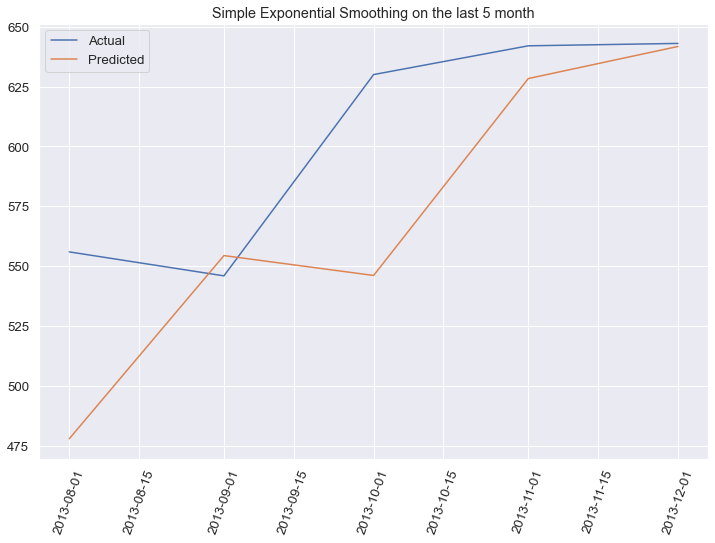

In [128]:
print(f'For alpha = {opt.x[0]:.5f}\nmape: {mape_score}\nmae: {mae_score}\n')
plot_results(predicted_values, title='Simple Exponential Smoothing on the last 5 month')

### Double exponential smoothing

#### Experimenting with parameters

In [27]:
alphas = [0.1, 0.9]
betas = [0.1, 0.9]

for alpha in alphas:
    for beta in betas:
        exp_smooth = exp_smooth_score([alpha, beta])
        predicted_values = exp_smooth['predicted']
        mape_errors = exp_smooth['mape']
        mae_errors = exp_smooth['mae']
        print(f'For alpha = {alpha}, beta = {beta}:\nmape = {np.mean(np.array(mape_errors))}\nmae = {np.mean(np.array(mae_errors))}\n')

For alpha = 0.1, beta = 0.1:
mape = 0.17898075337562527
mae = 108.30503221508145

For alpha = 0.1, beta = 0.9:
mape = 0.04056254828129298
mae = 24.72361767770992

For alpha = 0.9, beta = 0.1:
mape = 0.05979246964146202
mae = 35.3946911543365

For alpha = 0.9, beta = 0.9:
mape = 0.09536828032905528
mae = 56.45478104721102



#### Optimizing parameters

In [28]:
x = [0, 0]
opt = minimize(evaluate_mape, x0=x, bounds = ((0, 1), (0, 1)))
opt.x

array([0.00000000e+00, 1.80573107e-07])

In [29]:
exp_smooth = exp_smooth_score(opt.x)
mape_score = np.mean(np.array(exp_smooth['mape']))
mape_score

0.18849310354239546

In [129]:
x = [0.09, 0.8]
opt = minimize(evaluate_mape, x0=x, bounds = ((0.09, 1), (0.8, 1)))
opt.x

array([0.09      , 0.92699101])

In [130]:
exp_smooth = exp_smooth_score(opt.x)
predicted_values = exp_smooth['predicted']
mape_score = np.mean(np.array(exp_smooth['mape']))
mae_score = np.mean(np.array(exp_smooth['mae']))
mape_score

0.03905631284593765

For alpha = 0.09000, beta = 0.92699
mape: 0.03905631284593765
mae: 23.732592705391404


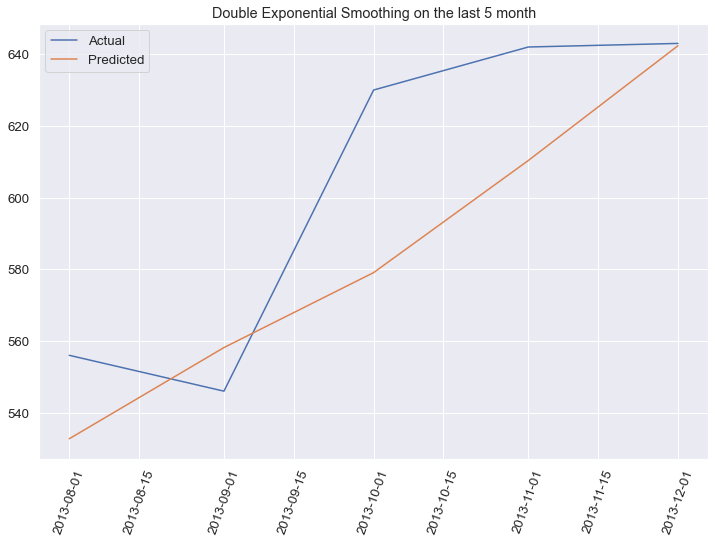

In [132]:
alpha, beta = opt.x
print(f'For alpha = {alpha:.5f}, beta = {beta:.5f}\nmape: {mape_score}\nmae: {mae_score}')

plot_results(predicted_values, title='Double Exponential Smoothing on the last 5 month')

### Triple exponential smoothing

#### Experimenting with parameters

In [33]:
alphas = [0.1, 0.9]
betas = [0.1, 0.9]
gammas = [0.1, 0.9]

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            exp_smooth = exp_smooth_score([alpha, beta, gamma])
            predicted_values = exp_smooth['predicted']
            mape_errors = exp_smooth['mape']
            mae_errors = exp_smooth['mae']
            print(f'For alpha = {alpha}, beta = {beta}, gamma = {gamma}:\nmape = {np.mean(np.array(mape_errors))}\nmae = {np.mean(np.array(mae_errors))}\n')

For alpha = 0.1, beta = 0.1, gamma = 0.1:
mape = 0.19766452293052322
mae = 119.07714569131397

For alpha = 0.1, beta = 0.1, gamma = 0.9:
mape = 0.12666703197433962
mae = 75.6692087302075

For alpha = 0.1, beta = 0.9, gamma = 0.1:
mape = 0.04133565100066507
mae = 24.71858150472956

For alpha = 0.1, beta = 0.9, gamma = 0.9:
mape = 0.03394911438112824
mae = 20.55015256033239

For alpha = 0.9, beta = 0.1, gamma = 0.1:
mape = 0.0650079474613667
mae = 38.28636562176865

For alpha = 0.9, beta = 0.1, gamma = 0.9:
mape = 0.06431167578312247
mae = 37.4305357448214

For alpha = 0.9, beta = 0.9, gamma = 0.1:
mape = 0.10680373228871828
mae = 62.9366212074175

For alpha = 0.9, beta = 0.9, gamma = 0.9:
mape = 0.08716622628966794
mae = 50.531717990968126



#### Optimizing parameters

In [34]:
x = [0, 0, 0]
opt = minimize(evaluate_mape, x0=x, bounds=((0, 1), (0, 1), (0, 1)))
opt.x

array([1.00000000e+00, 2.33181332e-06, 1.00000000e+00])

In [37]:
np.mean(np.array(exp_smooth_score(opt.x)['mape']))

0.06537506423570569

In [134]:
x = [0.09, 0.7, 0.7]
opt = minimize(evaluate_mape, x0=x, bounds=((0.09, 1), (0.7, 1), (0.7, 1)))
opt.x

array([0.09, 0.7 , 1.  ])

In [135]:
exp_smooth = exp_smooth_score(opt.x)
predicted_values = exp_smooth['predicted']
mape_score = np.mean(np.array(exp_smooth['mape']))
mae_score = np.mean(np.array(exp_smooth['mae']))
mape_score

0.033408261652010544

For alpha = 0.09, beta = 0.7, gamma = 1.0
mape: 0.033408261652010544
mae: 20.283248053222565



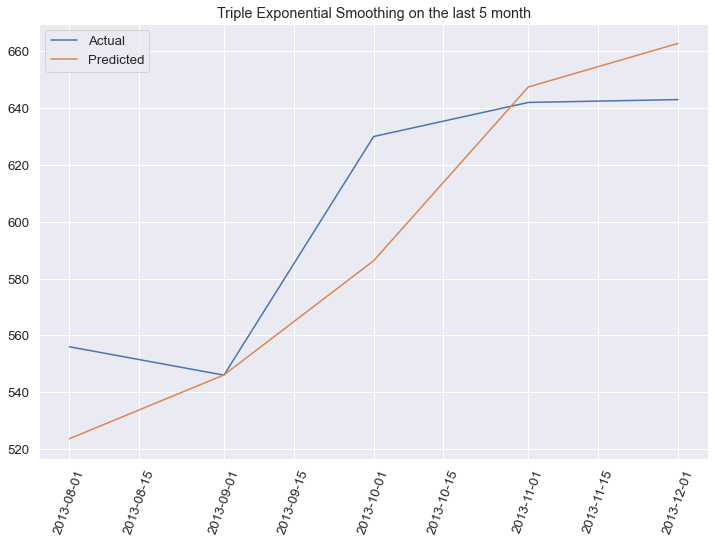

In [136]:
alpha, beta, gamma = opt.x
print(f'For alpha = {alpha}, beta = {beta}, gamma = {gamma}\nmape: {mape_score}\nmae: {mae_score}\n')

plot_results(predicted_values, title='Triple Exponential Smoothing on the last 5 month')

## Linear regression using Lag features

### Use two lags - initial model

In [121]:
data_lag = data.copy()
data_lag['Lag_sales'] = data_lag['Sales'].shift(periods=2)
data_lag['Lag_shipments'] = data_lag['Shipments'].shift(periods=1)
data_lag.dropna(inplace=True)

X, y = data_lag[['Lag_sales', 'BlackFriday', 'Lag_shipments']], data_lag[['Shipments']]

In [122]:
def evaluate_lr(X, y):
    tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

    mae_errors, mape_errors = [], []
    predicted_values = []
    for train, test in tscv.split(X):
        model = LinearRegression()
        model.fit(X.values[train], y.values[train])
        prediction = model.predict(X.values[test])
        predicted_values.append(prediction[0])
    
        mae_errors.append(mae(y.values[test], prediction))
        mape_errors.append(mape(y.values[test], prediction))
    
    mae_errors = np.mean(np.array(mae_errors))
    mape_errors = np.mean(np.array(mape_errors))

    print(f'mape = {mape_errors}\nmae = {mae_errors}\n')
    return predicted_values

mape = 0.0846821898595995
mae = 50.4684543985219



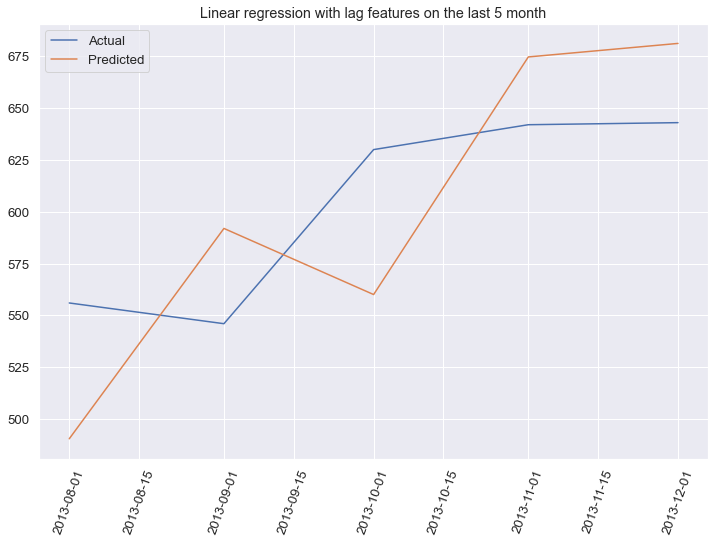

In [124]:
predicted_values = evaluate_lr(X, y)
plot_results(predicted_values, title='Linear regression with lag features on the last 5 month')

### Choose more lags from Partial Autocorrelation plot

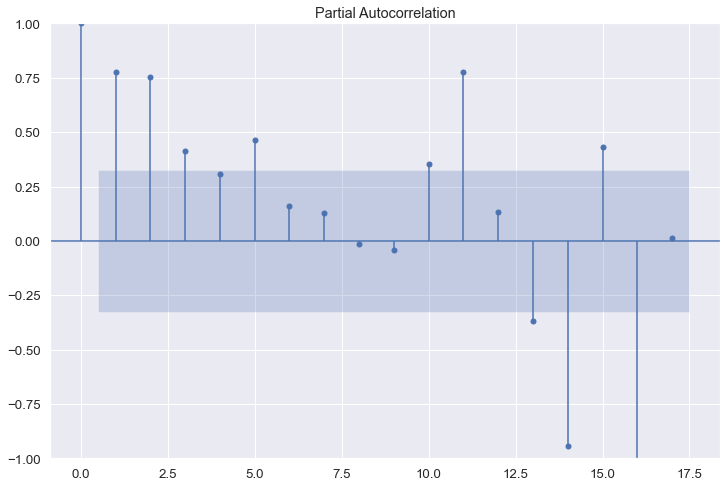

In [54]:
plot_pacf(data.Sales,lags=17, method='ols') 
plt.show()

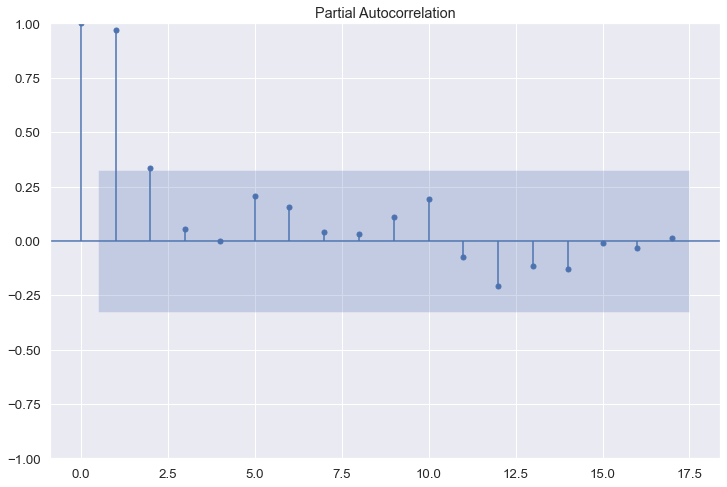

In [55]:
plot_pacf(data.Shipments,lags=17, method='ols') 
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
check_stationarity(data.Sales)

In [56]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'{ts.name}_lag_{i}': ts.shift(i)
            for i in lags
        },
        axis=1)

In [57]:
data_lag = data.copy()
X = make_lags(data_lag.Sales, [2, 5, 11])
y = make_lags(data_lag.Shipments, [1])

In [58]:
res = pd.concat([X, y], axis=1)
res.fillna(0, inplace=True)
res = pd.concat([res, data_lag[['BlackFriday']]], axis=1)

In [59]:
X, y = res, data_lag[['Shipments']]

mape = 0.08062110121074231
mae = 48.383774784986564



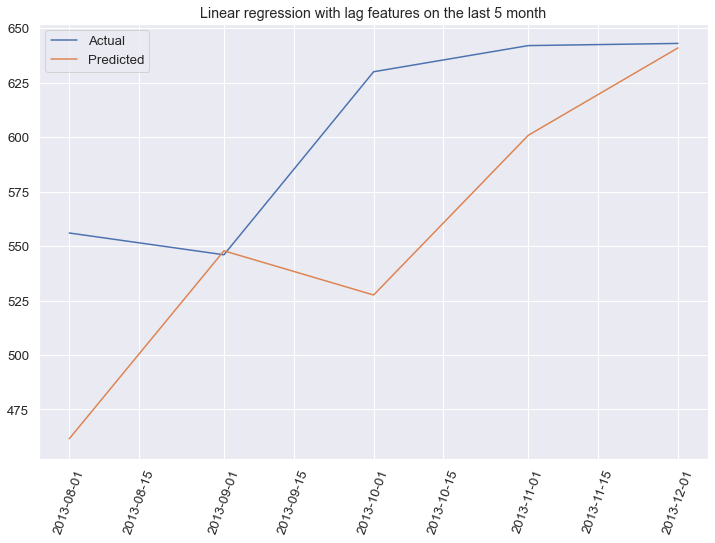

In [60]:
predicted_values = evaluate_lr(X, y)
plot_results(predicted_values, title='Linear regression with lag features on the last 5 month')

### With Feature Selection technique

#### Lasso + SelectFromModel

In [61]:
data_lag = data.copy()

sales_lags_count = [i for i in range(2, 18)]
shipments_lags_count = [i for i in range(1, 18)]
sales_lags = make_lags(data_lag.Sales, sales_lags_count)
shipments_lags = make_lags(data_lag.Shipments, shipments_lags_count)

res = pd.concat([sales_lags, shipments_lags], axis=1)

In [62]:
scaler = StandardScaler()
res_scaled = pd.DataFrame(scaler.fit_transform(res[:-5]), columns=res.columns)
res_scaled.fillna(0, inplace=True)

In [63]:
df_scaled = pd.concat([res_scaled, data_lag.BlackFriday[:-5].reset_index(drop=True)], axis=1)

In [64]:
X, y = df_scaled, scaler.fit_transform(data_lag[['Shipments']][:-5])

In [65]:
selection_model = Lasso(alpha=0.1).fit(X, y)
model = SelectFromModel(selection_model).fit(X, y)

In [66]:
columns_to_keep = df_scaled.columns[model.get_support()].values.tolist()
columns_to_keep

['Sales_lag_2',
 'Sales_lag_3',
 'Sales_lag_4',
 'Shipments_lag_1',
 'Shipments_lag_2',
 'Shipments_lag_3']

In [67]:
delete = [c for c in res.columns.values.tolist() if c not in columns_to_keep]
reduced_data = res.drop(delete, axis=1)

In [68]:
reduced_data.fillna(0, inplace=True)

In [69]:
X, y = reduced_data, data_lag['Shipments']

mape = 0.07573257282850883
mae = 44.86199302760569



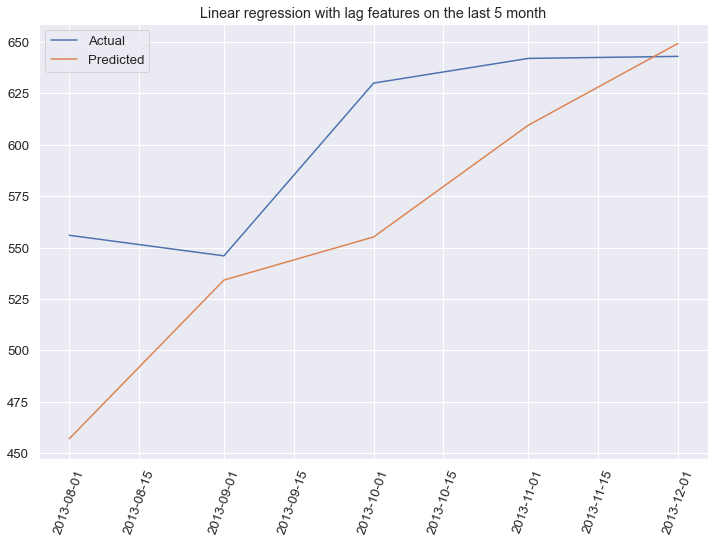

In [70]:
predicted_values = evaluate_lr(X, y)
plot_results(predicted_values, title='Linear regression with lag features on the last 5 month')

#### GridSearch + Lasso

In [71]:
parameters = {
    'alpha': np.linspace(0.1, 1, 10), 
    'fit_intercept':['True', 'False'],
    'max_iter': np.linspace(100, 1500, 8),
    'tol':np.linspace(0.0001, 0.001, 4)
}

In [72]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

grid = GridSearchCV(Lasso(), 
                    parameters, 
                    cv=tscv, 
                    scoring='neg_mean_absolute_percentage_error')

In [73]:
X, y = df_scaled, scaler.fit_transform(data_lag[['Shipments']][:-5])
grid_result = grid.fit(X, y)

In [74]:
grid_result.best_params_

{'alpha': 0.1, 'fit_intercept': 'True', 'max_iter': 100.0, 'tol': 0.0001}

#### RandomForestRegressor + Boruta

In [76]:
forest = RandomForestRegressor(
    n_jobs=-1, 
    max_depth=5
)
boruta = BorutaPy(
    estimator=forest, 
    n_estimators='auto',
    max_iter=100 
)

In [77]:
res = pd.concat([res, data_lag.BlackFriday], axis=1).fillna(0)
X, y = res, data_lag['Shipments']

In [78]:
X_train, y_train = X[:-5], y[:-5]
boruta.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=89,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F8213DBF140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F8213DBF140)

In [79]:
cols = X.columns[boruta.support_].to_list()
cols

['Sales_lag_2',
 'Shipments_lag_1',
 'Shipments_lag_2',
 'Shipments_lag_3',
 'Shipments_lag_4',
 'Shipments_lag_17']

In [80]:
delete = [c for c in res.columns.values.tolist() if c not in cols]
reduced_data = res.drop(delete, axis=1)

mape = 0.10604132507702028
mae = 63.092572153696665



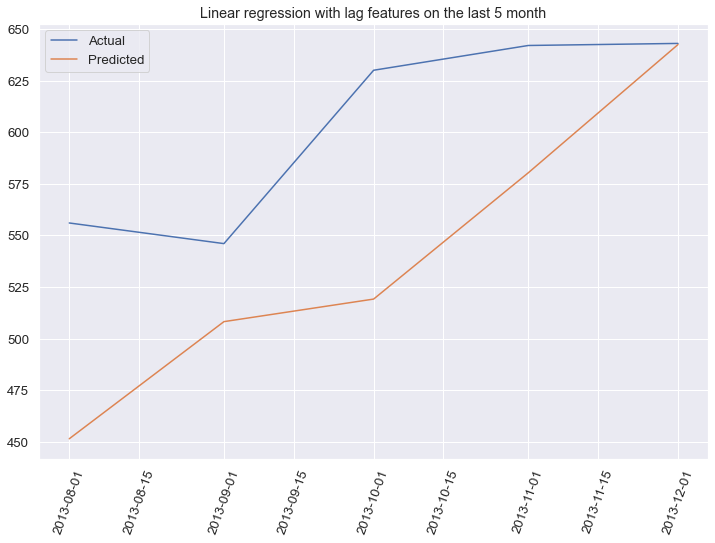

In [81]:
predicted_values = evaluate_lr(reduced_data, data_lag['Shipments'])
plot_results(predicted_values, title='Linear regression with lag features on the last 5 month')

#### GridSearch + RandomForestRegressor

In [82]:
parameters = {
    'n_estimators': [10, 40, 70, 100, 130],
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [3, 7, 11, 15],
    'min_samples_split': [2, 4, 6]
}

In [83]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), 
                    parameters, 
                    cv=tscv, 
                    scoring='neg_mean_absolute_percentage_error')

grid_result = grid.fit(X_train, y_train)

In [84]:
grid_result.best_params_

{'criterion': 'poisson',
 'max_depth': 7,
 'min_samples_split': 2,
 'n_estimators': 10}

In [85]:
forest = RandomForestRegressor(
    n_estimators=10,
    criterion='poisson',
    max_depth=7,
    n_jobs=-1
)
boruta = BorutaPy(
    estimator=forest, 
    n_estimators='auto',
    max_iter=100 
)

In [86]:
boruta.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestRegressor(criterion='poisson', max_depth=7,
                                         n_estimators=75, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F8213DBF140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F8213DBF140)

In [87]:
cols = X.columns[boruta.support_].to_list()
cols

['Sales_lag_2',
 'Sales_lag_3',
 'Sales_lag_4',
 'Sales_lag_5',
 'Shipments_lag_1',
 'Shipments_lag_2',
 'Shipments_lag_3',
 'Shipments_lag_4',
 'Shipments_lag_5',
 'Shipments_lag_6',
 'Shipments_lag_7']

In [88]:
delete = [c for c in res.columns.values.tolist() if c not in cols]
reduced_data = res.drop(delete, axis=1)

mape = 0.08108313575648113
mae = 47.97033217409991



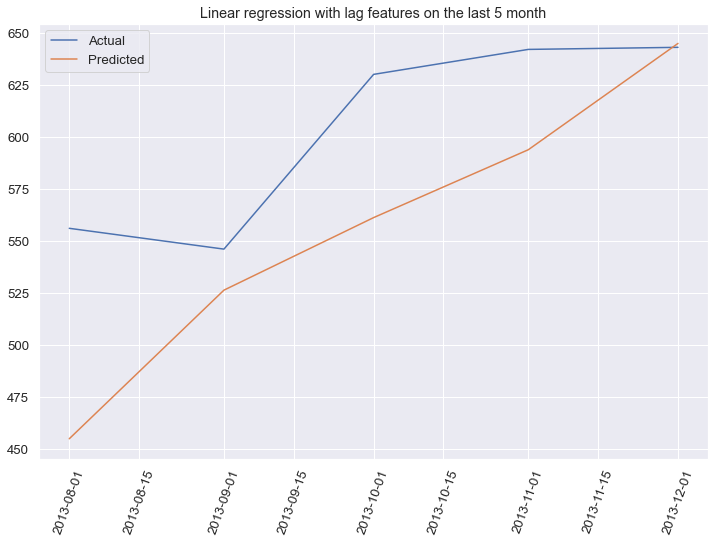

In [89]:
predicted_values = evaluate_lr(reduced_data, data_lag['Shipments'])
plot_results(predicted_values, title='Linear regression with lag features on the last 5 month')

## Phrophet

In [90]:
data_prophet = data.copy()

In [91]:
data_prophet.reset_index(inplace=True)
data_prophet = data_prophet.rename(columns = {'Date': 'ds',
                                              'Shipments': 'y'})
data_prophet = data_prophet.loc[:, ['ds', 'y']]

### Initial prophet

In [92]:
def validate_prophet(holidays=None):
    values = data_prophet.values
    tscv = TimeSeriesSplit(n_splits=5, test_size=1, gap=1) 

    mae_errors, mape_errors = [], []
    predicted_values = []
    for train, test in tscv.split(values):
        df_train = pd.DataFrame(values[train]).rename(columns = {0: 'ds', 1: 'y'})
        model = Prophet(holidays=holidays)
        model.fit(df_train)
    
        future_date = pd.DataFrame(data_prophet.iloc[test[0]]).T[['ds']]
        prediction = model.predict(future_date)
        predicted_values.append(prediction.yhat)
    
        mae_errors.append(mae(np.array([data_prophet.iloc[test[0]].values[1]]), np.array([prediction.yhat.values[0]])))
        mape_errors.append(mape(np.array([data_prophet.iloc[test[0]].values[1]]), np.array([prediction.yhat.values[0]])))
    
    mae_errors = np.mean(np.array(mae_errors))
    mape_errors = np.mean(np.array(mape_errors))

    print(f'mape = {mape_errors}\nmae = {mae_errors}\n')
    return predicted_values

In [93]:
predicted_init = validate_prophet()


Initial log joint probability = -46.5606
Iteration  1. Log joint probability =    28.3813. Improved by 74.9418.
Iteration  2. Log joint probability =    43.2674. Improved by 14.8862.
Iteration  3. Log joint probability =    49.9235. Improved by 6.65611.
Iteration  4. Log joint probability =    55.5987. Improved by 5.6752.
Iteration  5. Log joint probability =    60.1062. Improved by 4.5075.
Iteration  6. Log joint probability =    60.1337. Improved by 0.027481.
Iteration  7. Log joint probability =     60.184. Improved by 0.050355.
Iteration  8. Log joint probability =    60.2617. Improved by 0.0776683.
Iteration  9. Log joint probability =    60.3526. Improved by 0.0908426.
Iteration 10. Log joint probability =    60.3777. Improved by 0.0251072.
Iteration 11. Log joint probability =    60.4085. Improved by 0.0308403.
Iteration 12. Log joint probability =    60.4239. Improved by 0.0153591.
Iteration 13. Log joint probability =    60.4315. Improved by 0.00766746.
Iteration 14. Log join

### Phrophet with holidays

In [94]:
black_friday = promo_data.reset_index()
black_friday.columns = ['ds', 'holiday']

predicted_adv = validate_prophet(holidays=black_friday)


Initial log joint probability = -49.7821
Iteration  1. Log joint probability =    28.3813. Improved by 78.1634.
Iteration  2. Log joint probability =    43.2969. Improved by 14.9156.
Iteration  3. Log joint probability =    49.7591. Improved by 6.46225.
Iteration  4. Log joint probability =    55.2151. Improved by 5.45598.
Iteration  5. Log joint probability =    60.1216. Improved by 4.90646.
Iteration  6. Log joint probability =    60.1499. Improved by 0.0282926.
Iteration  7. Log joint probability =    60.2006. Improved by 0.0506869.
Iteration  8. Log joint probability =    60.2774. Improved by 0.0768801.
Iteration  9. Log joint probability =     60.364. Improved by 0.0865796.
Iteration 10. Log joint probability =    60.4083. Improved by 0.0442961.
Iteration 11. Log joint probability =    60.4393. Improved by 0.0309582.
Iteration 12. Log joint probability =    60.4546. Improved by 0.0153449.
Iteration 13. Log joint probability =    60.6413. Improved by 0.186664.
Iteration 14. Log jo

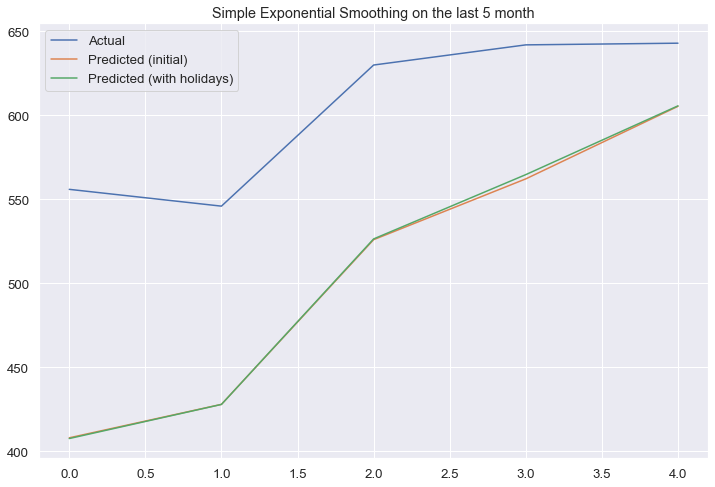

In [95]:
plt.figure(figsize=(12,8))
plt.plot(true_values, label='Actual')
plt.plot(predicted_init, label='Predicted (initial)')
plt.plot(predicted_adv, label='Predicted (with holidays)')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing on the last 5 month')
plt.show()

### Make next month prediction with Triple Exponential Smoothing

In [100]:
alpha, beta, gamma = 0.09, 0.7, 1
model = ExponentialSmoothing(data.Shipments.values, trend='additive', 
                                         seasonal='additive', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
        
predictions = model.forecast(1)
predictions

array([678.39902841])